In [1]:
import gymnasium as gym
import torch.nn as nn
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
import os


In [2]:
class DiscretePendulum(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}
    
    def __init__(self, n_bins=9):
        super(DiscretePendulum, self).__init__()
        self.env = gym.make('Pendulum-v1')
        
        self.action_space = gym.spaces.Discrete(n_bins)
        self.observation_space = self.env.observation_space

        self.nbins = n_bins

    def reset(self, seed=None):
        return self.env.reset(seed=seed)

    def step(self, action):
        # Map action to continuous action space
        action = (4 * action / (self.nbins - 1)) - 2
        return self.env.step([action])

    def render(self, mode="human"):
        return self.env.render(mode)

    def close(self):
        return self.env.close()
    
check_env(DiscretePendulum())

In [3]:

policy_kwargs = dict(activation_fn=nn.LeakyReLU, net_arch=[32, 32, 32])

n_training = 200
n_total = 200
ep_size = 200
batch_size = 1

env = DiscretePendulum()

model = DQN("MlpPolicy", env, policy_kwargs=policy_kwargs, gradient_steps=-1, batch_size=batch_size) #, max_grad_norm=1)
model.learn(total_timesteps=n_training * ep_size)


import wandb

os.environ["WANDB_NOTEBOOK_NAME"] = "dqn_baseline.ipynb"

wandb.init(
    project="dqn-pendulum",
    config={
        "type": "StableBaselines3 DQN",
        "batch_size": batch_size,
        "buffer_type" : "Built-in",
        "compile": True,
    }
)


obs, info = env.reset()
i = 0
rewards = 0
all_rewards = []
while i < n_total:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    rewards += reward
    if terminated or truncated:
        obs, info = env.reset()
        print(f"Episode {i} finished, with reward {rewards}", flush=True)
        wandb.log({"reward": rewards})
        all_rewards.append(rewards)
        rewards = 0
        i += 1
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: unevilicorn (unevilicorn-org). Use `wandb login --relogin` to force relogin


Episode 0 finished, with reward -1252.8306041325545
Episode 1 finished, with reward -1311.6356110793604
Episode 2 finished, with reward -1469.472848674274
Episode 3 finished, with reward -1196.067442222822
Episode 4 finished, with reward -1342.7780210855015
Episode 5 finished, with reward -1409.6101419108265
Episode 6 finished, with reward -1493.418132900937
Episode 7 finished, with reward -1523.1067178573794
Episode 8 finished, with reward -1398.3705826626353
Episode 9 finished, with reward -1249.1591899847165
Episode 10 finished, with reward -1461.5129174466501
Episode 11 finished, with reward -1433.2592082552655
Episode 12 finished, with reward -1109.7995745686674
Episode 13 finished, with reward -1440.2893706600616
Episode 14 finished, with reward -1493.8356844947612
Episode 15 finished, with reward -1281.8524352622846
Episode 16 finished, with reward -1406.4776052161037
Episode 17 finished, with reward -1357.9023076957599
Episode 18 finished, with reward -1442.1374849727854
Episod

reward,▅▃▃▅▂▃▁▃▁▁▃▄▂▁▂▃▁▁▂█▂▄▁▂▁▄▇▇▄▄▁▄▂▃▂▁▃▂▁▂
reward,-1487.80826


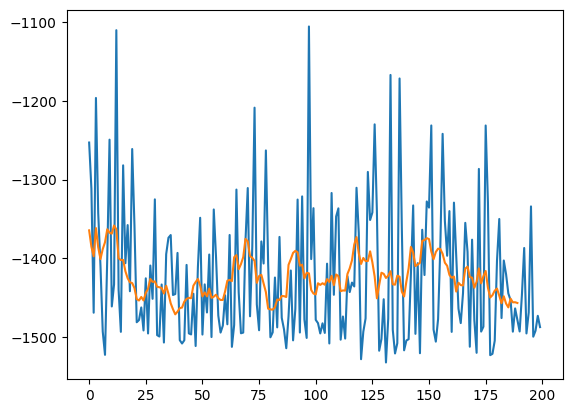

In [4]:
import matplotlib.pyplot as plt
# plot all rewards as it is and also the average of the last 10 rewards
plt.plot(all_rewards)
plt.plot([sum(all_rewards[i:i+10])/10 for i in range(len(all_rewards)-10)])
plt.show()